In [35]:
# setting up the notebook for data visualization and report design
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import table
from matplotlib.ticker import MaxNLocator
import seaborn as sns
import os
import datetime
from reportlab.pdfgen import canvas
from reportlab.lib.units import cm
from reportlab.platypus import SimpleDocTemplate, Paragraph
from fpdf import FPDF
from PyPDF2 import PdfMerger

import img2pdf
#os.listdir(os.getcwd())

In [36]:
number_of_files = 2 # plotting two graphs in one
path1 = 'data/2.csv'
path2 = 'data/3.csv'
date_now = datetime.datetime.now() 
date_to_print = date_now.strftime("%Y-%m-%d") # adding today's date
print(date_to_print)

2022-11-24


In [37]:
# creating data frames
def data_files(path):
    try:
        df_raw = pd.read_csv(path, sep=';')
        file_name = str(path[5:-4])
        if list(df_raw.columns) != ['d_max(um)', 'd_min(um)', 'd_avg(um)', 'delta d ']:
            print(f'wrong {file_name} file')
        else:
            df = df_raw.dropna()
            df.rename(columns = {'d_max(um)':'diameter_max, um', 'd_min(um)':'diameter_min, um',
            'd_avg(um)':'average_diameter, um','delta d ':'delta_diameter, um'}, inplace = True)
        return df, file_name
    except FileNotFoundError:
        print(f'wrong file {path}')
        

df1, file_name_1 = data_files(path1)[0], data_files(path1)[1]
df2, file_name_2 = data_files(path2)[0], data_files(path2)[1]

In [38]:
df1.head()

,"diameter_max, um","diameter_min, um","average_diameter, um","delta_diameter, um"
0,500.187,499.803,499.995,0.384
1,500.326,499.975,500.150,0.351
2,500.330,499.856,500.093,0.474
3,500.366,500.123,500.244,0.243
4,500.526,500.123,500.324,0.403


In [39]:
# new folder for graphs
script_dir = os.path.dirname('data') 
results_dir = os.path.join(script_dir, 'results '+file_name_1+' '+date_to_print+'/')

if not os.path.isdir(results_dir):
    os.makedirs(results_dir)
print(f'graphs will be saved in folder named "results {file_name_1} {date_to_print}"')

graphs will be saved in folder named "results 2 2022-11-24"


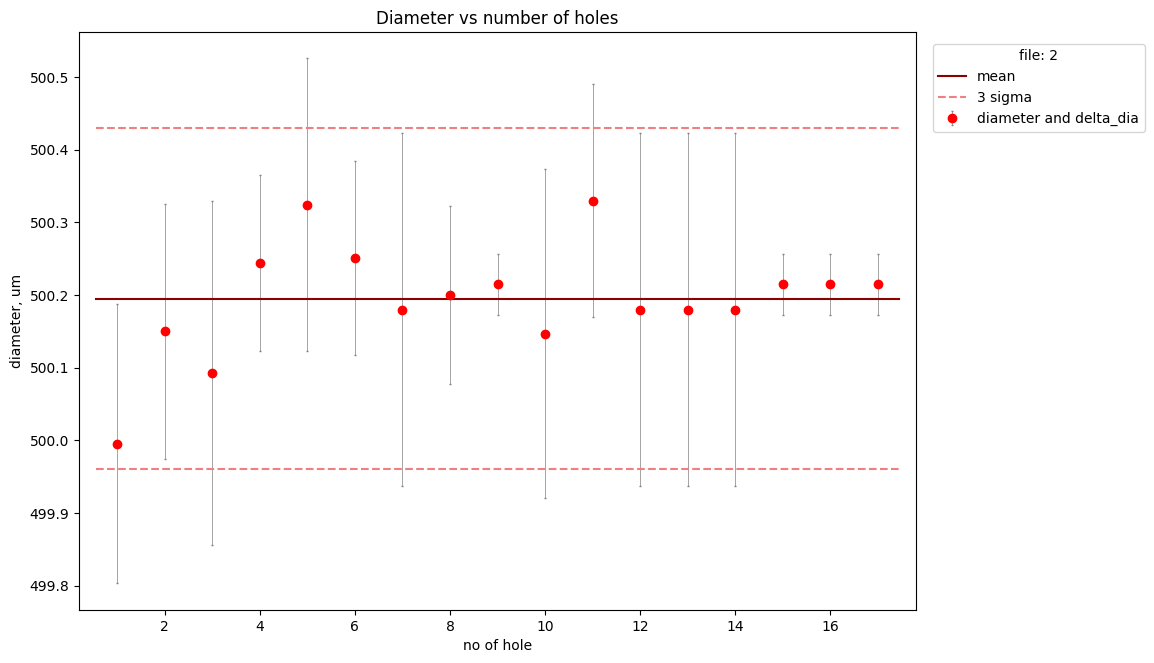

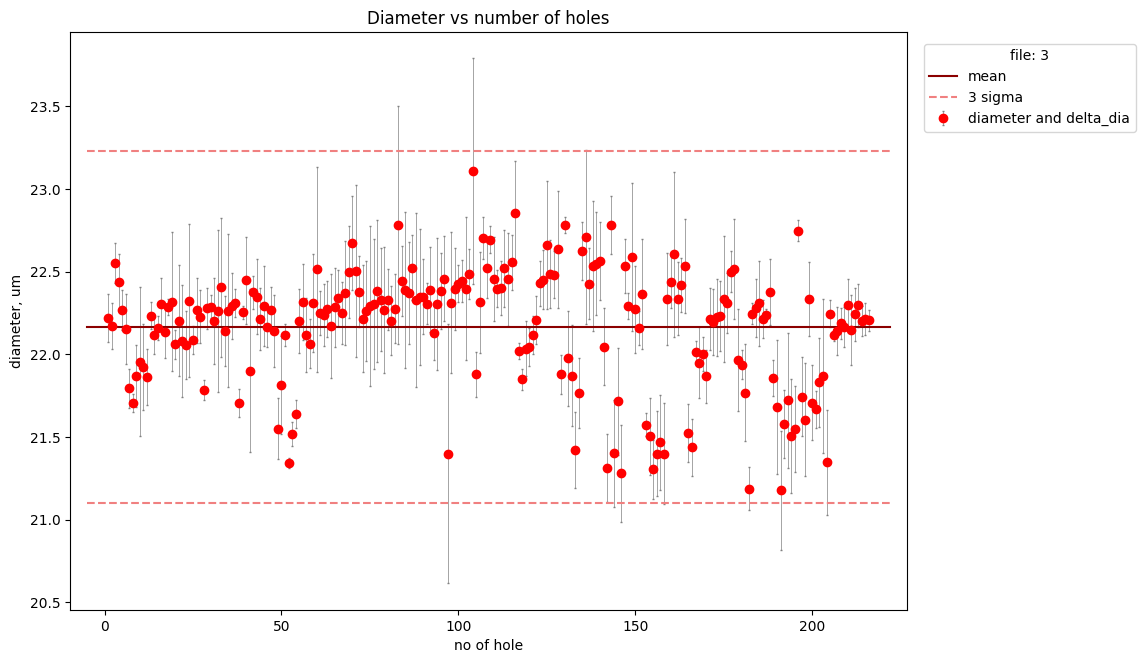

In [40]:
# plotting the hole diameter for each hole and errors ((the major axis - the minor axis)/2),
# the mean value and the 3 sigma values 
def graph_dia(df, file_name):
    count_row = df.shape[0]
    sigma_x = round(df['average_diameter, um'].std(),4)
    mean_d = round(df['average_diameter, um'].mean(),4)
    x = df.index = np.arange(1, count_row+1)
    y = df['average_diameter, um']
    y_d = df['delta_diameter, um']
    plt.figure(figsize=(10.8,7.5))
    plt.xlabel('no of hole')
    plt.ylabel('diameter, um')
    plt.title('Diameter vs number of holes')
    plt.errorbar(x, y, y_d/2, fmt='ro', elinewidth=0.5, ecolor='0.5',
        capsize=1, capthick=1,label='diameter and delta_dia')
    plt.axhline(y=mean_d, color='darkred', linestyle='-', xmin=0.02, xmax=0.98, label='mean')
    plt.axhline(y=mean_d+(sigma_x)*3, color='lightcoral', linestyle='--',
        xmin=0.02, xmax=0.98, label='3 sigma')
    plt.axhline(y=mean_d-(sigma_x)*3, color='lightcoral', xmin=0.02, xmax=0.98, linestyle='--')
    plt.legend(bbox_to_anchor=(1.02, 0.98), loc='upper left', borderaxespad=0, title= 'file: '+file_name)
    plt.savefig(results_dir+file_name+'.png', bbox_inches="tight", pad_inches=0.2,transparent=True,
        facecolor="w",edgecolor='w', orientation='landscape')
    return plt.show()


graph_dia(df1, file_name_1)
graph_dia(df2, file_name_2)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


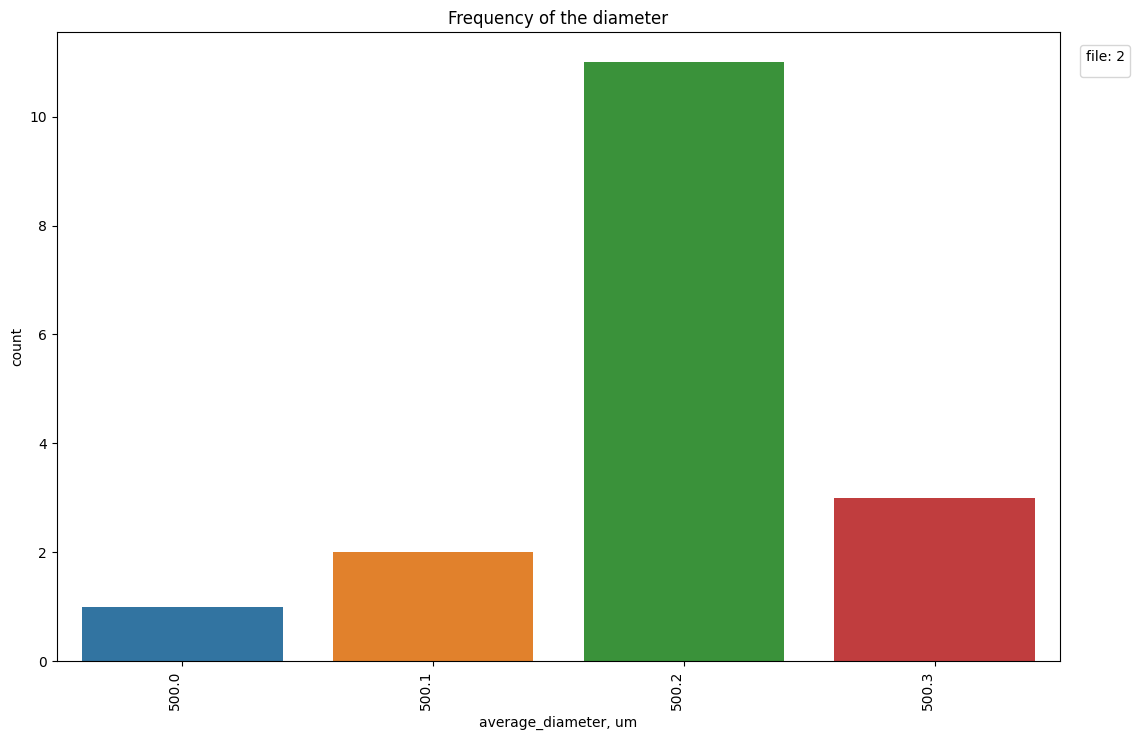

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


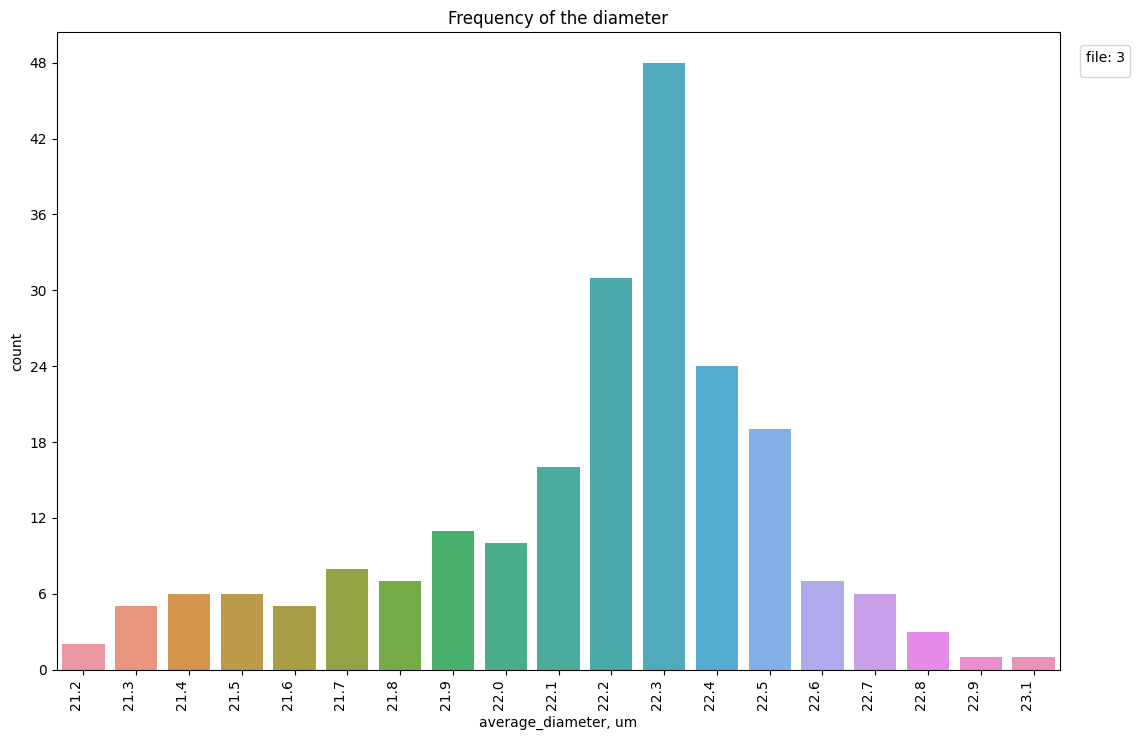

In [41]:
# frequency distribution for the diameters
def graph_freq(df, file_name, decimal_numeral):
    plt.figure(figsize=(10.8,7.5))
    ax=sns.countplot(x=df['average_diameter, um'].round(decimals = decimal_numeral))
    ax.set_title('Frequency of the diameter')
    ax.set_xticklabels(ax.get_xticklabels(), rotation=90, ha="right")
    ax.yaxis.set_major_locator(MaxNLocator(integer=True))
    plt.tight_layout()
    plt.legend(bbox_to_anchor=(1.02,0.98), loc='upper left', borderaxespad=0, title= 'file: '+file_name)
    plt.savefig(results_dir+file_name+'freq.png', bbox_inches="tight", pad_inches=0.2,transparent=True,
        facecolor="w",edgecolor='w')
    return plt.show()

graph_freq(df1, file_name_1, 1)
graph_freq(df2, file_name_2, 1)

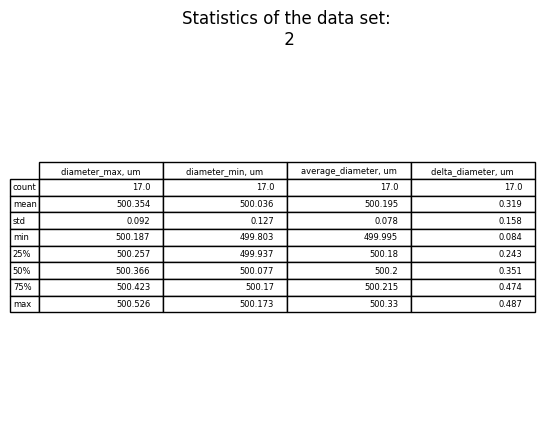

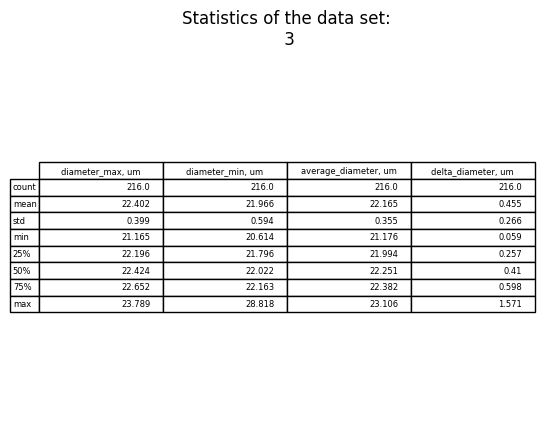

In [42]:
# basic statistical information
def main_stats(df, file_name, save = False):
    stats_data = df.describe(include='all').round(decimals = 3)
    ax = plt.subplot(111, frame_on=False)
    ax.set_title(f'Statistics of the data set:\n {file_name}')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
    table(ax, stats_data, loc='center')
    if save==True:
        plt.savefig(results_dir+file_name+' stats.png', bbox_inches='tight', pad_inches=0)
    return plt.show()

main_stats(df1, file_name_1, save=False)
main_stats(df2, file_name_2, save=False)

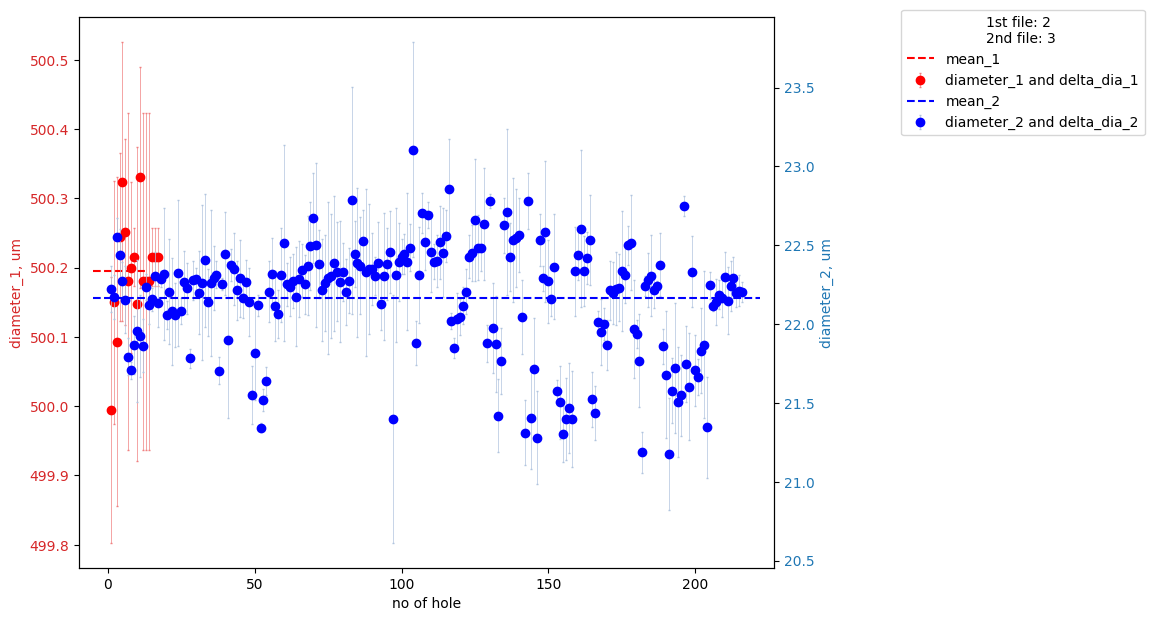

In [45]:
# plotting two data sets 
def graph_dia_2(df1, df2):
    if number_of_files >= 2:
        if df2.shape[0]==df1.shape[0]:
            max1 = max2 = 0.98
        if df2.shape[0]>df1.shape[0]:
            max1 = (df1.shape[0]/df2.shape[0])+0.02
            max2 = 0.98
        if df1.shape[0]>df2.shape[0]:
            max1 = 0.98
            max2 = (df2.shape[0]/df1.shape[0])+0.02
        fig, ax1 = plt.subplots()
        color = 'tab:red'
        ax1.set_xlabel('no of hole')
        ax1.set_ylabel('diameter_1, um', color=color)
        x = df1.index = np.arange(1, df1.shape[0]+1)
        y = df1['average_diameter, um']
        y_d = df1['delta_diameter, um']
        mean_d1 = round(df1['average_diameter, um'].mean(),4)
        ax1.errorbar(x, y, y_d/2, fmt='ro', elinewidth=0.5, ecolor='lightcoral',
                    capsize=1, capthick=1,label='diameter_1 and delta_dia_1')
        ax1.axhline(y=mean_d1, color='r', linestyle='--', xmin=0.02, xmax=max1, label='mean_1')
        ax1.tick_params(axis='y', labelcolor=color)

        ax2 = ax1.twinx()
        color = 'tab:blue'
        ax2.set_ylabel('diameter_2, um', color=color)
        x2 = df2.index = np.arange(1, df2.shape[0]+1)
        y2 = df2['average_diameter, um']
        y_d2 = df2['delta_diameter, um']
        mean_d2 = round(df2['average_diameter, um'].mean(),4)
        ax2.errorbar(x2, y2, y_d2/2, fmt='bo', elinewidth=0.5, ecolor='lightsteelblue',
                    capsize=1, capthick=1, label='diameter_2 and delta_dia_2')
        ax2.axhline(y=mean_d2, color='b', linestyle='--', xmin=0.02, xmax=max2, label='mean_2')
        ax2.tick_params(axis='y', labelcolor=color)
        fig.tight_layout()
        fig.legend(bbox_to_anchor=(1.02,0.98), loc='upper left', borderaxespad=0 ,
                    title= '1st file: '+ file_name_1 +'  \n2nd file: '+ file_name_2)
        fig.set_figheight(6.5)
        fig.set_figwidth(9.25)
        plt.savefig(results_dir + file_name_1 + '&' + file_name_2 + '.png', bbox_inches="tight",
                    pad_inches=0.2, transparent=True, facecolor="w", edgecolor='w')
        return plt.show()

graph_dia_2(df1, df2)

In [46]:
# save all graphs to .pdf file
def graphs_pdf(report = True, title_page = True):
	if report == True:
		if title_page == True:
			report_name = 'data for ' + file_name_1 + ' without title page.pdf'
		if title_page == False:
			report_name = 'data for ' + file_name_1 + '.pdf'
		dirname = results_dir
		imgs = []

		for r, _, f in os.walk(dirname):
			for fname in f:
				if not fname.endswith('.png'):
					continue
				imgs.append(os.path.join(r, fname))

		with open(report_name,'wb') as f:
			f.write(img2pdf.convert(imgs))
			if title_page == True:
				print('for the title page additional information is needed!')
			print('Both tables and graphs are saved in the PDF output file:')
		return report_name

graphs_pdf(report = True, title_page = True)

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


for the title page additional information is needed!
Both tables and graphs are saved in the PDF output file:


'data for 2 without title page.pdf'

In [47]:
# creating the title page: title and drawing are required, subtitle is optional
def title_pdf(title_page=True):
    #title = input('enter title: ')
    #sub_title = input('enter subtitle:(press space bar if subtitle is not needed)')
    #text = input('enter name of text file (with .txt extension) or press "q" if text if not needed')
    #drawing = input('enter name of image file with extension (max heigh: 15 cm, max width: 28.7 cm)')
    title = 'Glass micromachining'
    sub_title = '280 holes (dia 100 um) in fused silica glass'
    text = 'example_text.txt'
    drawing = 'example_drawing.jpg'
    title_p=f'title page {file_name_1}.pdf'

    c = canvas.Canvas(title_p,bottomup=1)
    c.setPageSize((29.7 * cm, 21 * cm))
    x0 = c._pagesize[0] / 2
    c.setFont('Times-Roman', 26)
    c.drawCentredString(x0, 18.3*cm, title)
    c.setFont('Times-Roman', 22)
    c.drawCentredString(x0, 17*cm, sub_title)
    c.setFont('Times-Roman', 18)
    c.line(1*cm, 16*cm, 28.7*cm, 16*cm)
    start_y = 15.5*cm
    if text != 'q' or 'Q':
        for line in open(f'{text}','r', encoding="utf-8"):
            start_y -= 0.9*cm
            c.drawString(1.5*cm, start_y, line.strip())

    c.drawString(1*cm, 20*cm, f'Date: {date_to_print}')
    c.drawImage(drawing,1*cm, 1*cm)
    c.showPage()
    c.save()
    return title_p
title_pdf()

'title page 2.pdf'

In [48]:
# adding the title page to the PDF file
pdf1 = title_pdf()
pdf2 = graphs_pdf()
pdfs = [pdf1, pdf2]

merger = PdfMerger()

for pdf in pdfs:
    merger.append(pdf)

merger.write(f'title page and {graphs_pdf()}')
merger.close()

Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


for the title page additional information is needed!
Both tables and graphs are saved in the PDF output file:


Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.
Image contains an alpha channel. Computing a separate soft mask (/SMask) image to store transparency in PDF.


for the title page additional information is needed!
Both tables and graphs are saved in the PDF output file:
